In [1]:
!pip install tensorflow==2.15.0
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install sklearn
!pip install wordcloud
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
# Import Deep learning packages

!pip install keras
!pip install tensorflow # install the latest version of tensorflow
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot # import one_hot from tensorflow.keras.preprocessing.text
from keras.utils import to_categorical

In [3]:
# Import Machine Learning Packages

from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import pickle
import nltk
import re
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Load the data

In [4]:
train_data=pd.read_csv('train.txt',header=None,sep=";",names=['Comment','Emotion'],encoding='utf-8')

# For finding the length of the comments(characters including space)

train_data['length']=[len(x) for x in train_data['Comment']]

In [5]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [6]:
train_data.shape

(16000, 3)

In [7]:
train_data.isnull().sum()

,0
Comment,0
Emotion,0
length,0


In [8]:
train_data.duplicated().sum()

1

In [9]:
train_data.drop_duplicates(inplace=True) # remove duplicate data

In [10]:
train_data.duplicated().sum()

0

EDA

In [11]:
train_data['Emotion'].value_counts()

,count
Emotion,
joy,5361
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


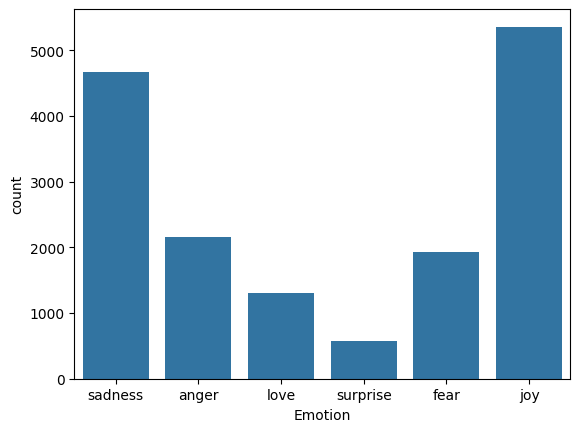

In [12]:
sns.countplot(x='Emotion',data=train_data)
plt.show() # plot shows data is imbalanced

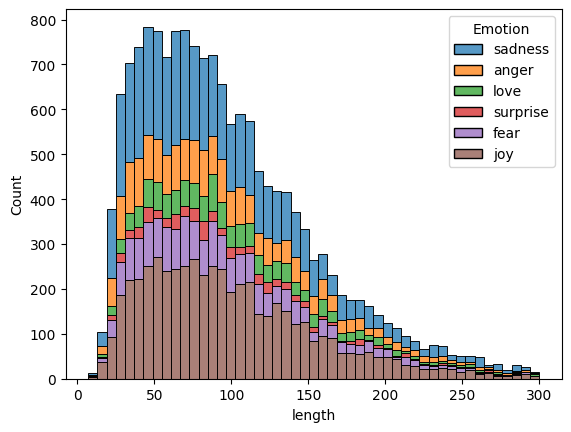

In [13]:
# check data distribution and plot it

df2=train_data.copy()

# convert the length column into numpy array
length_values=df2['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2,x='length',hue='Emotion',multiple='stack')
plt.show()

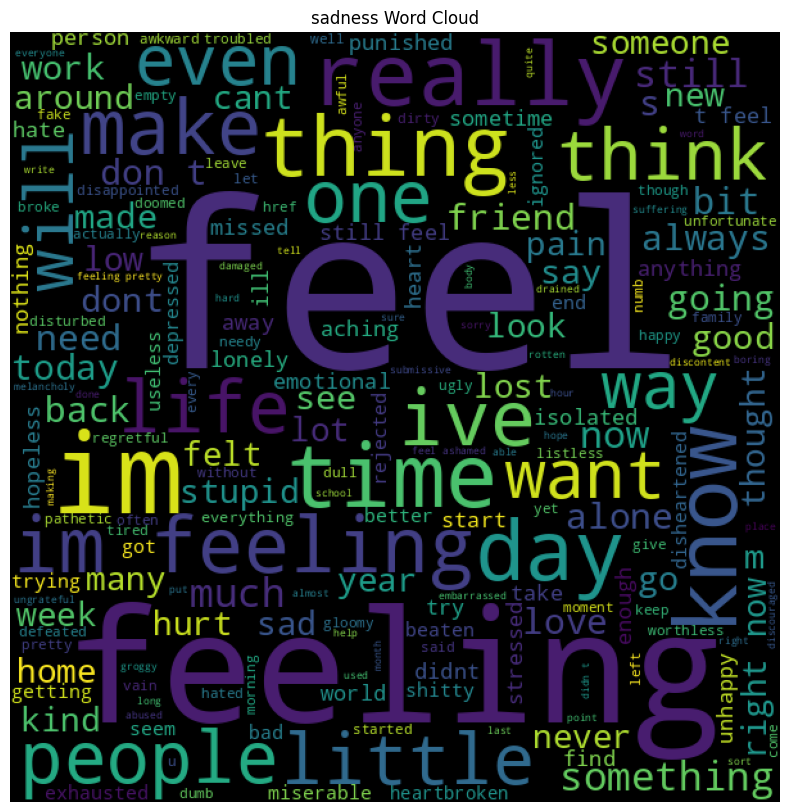

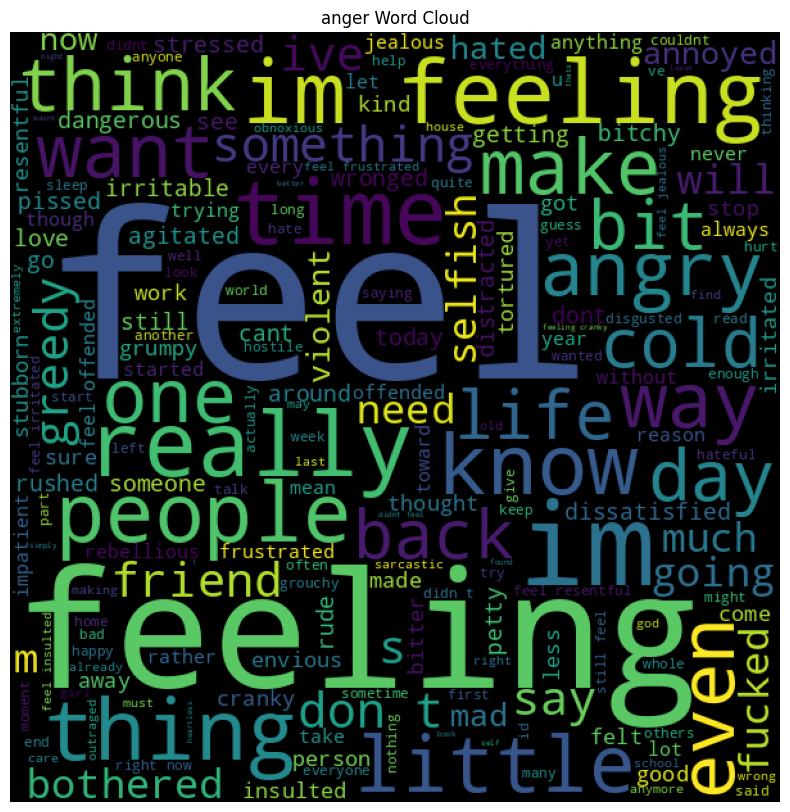

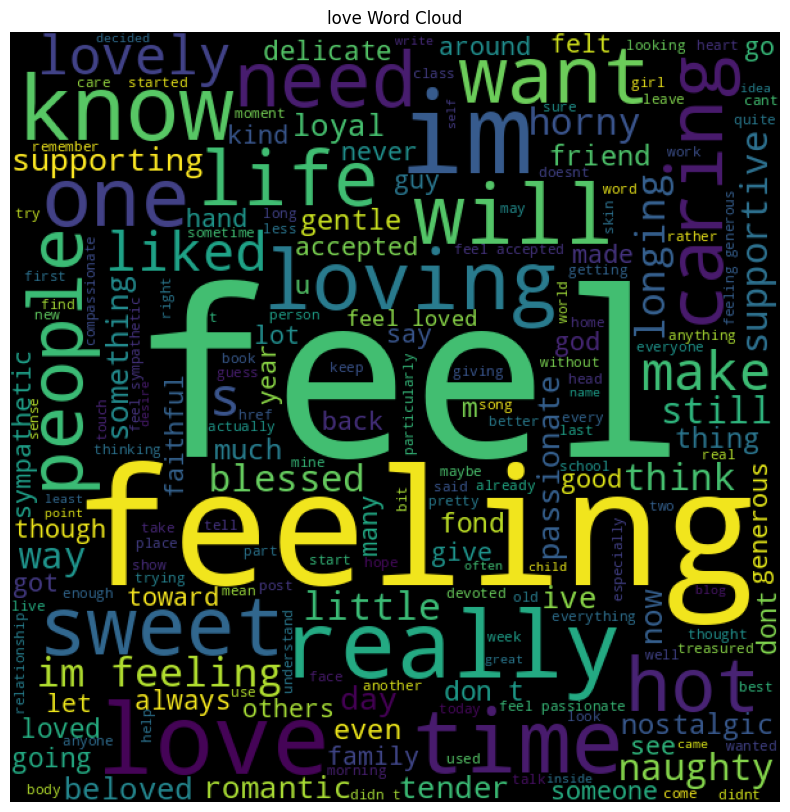

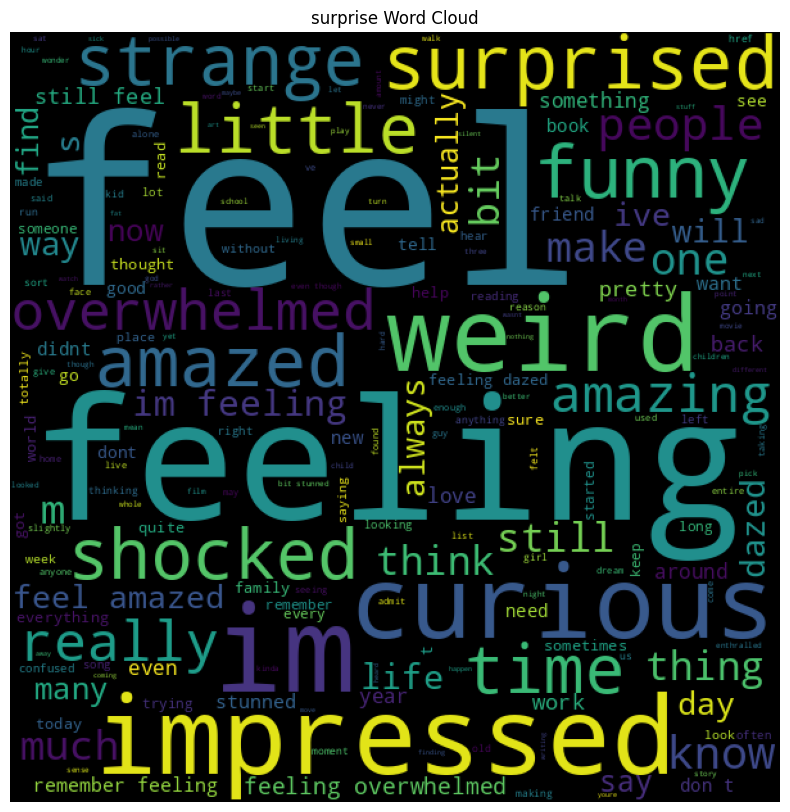

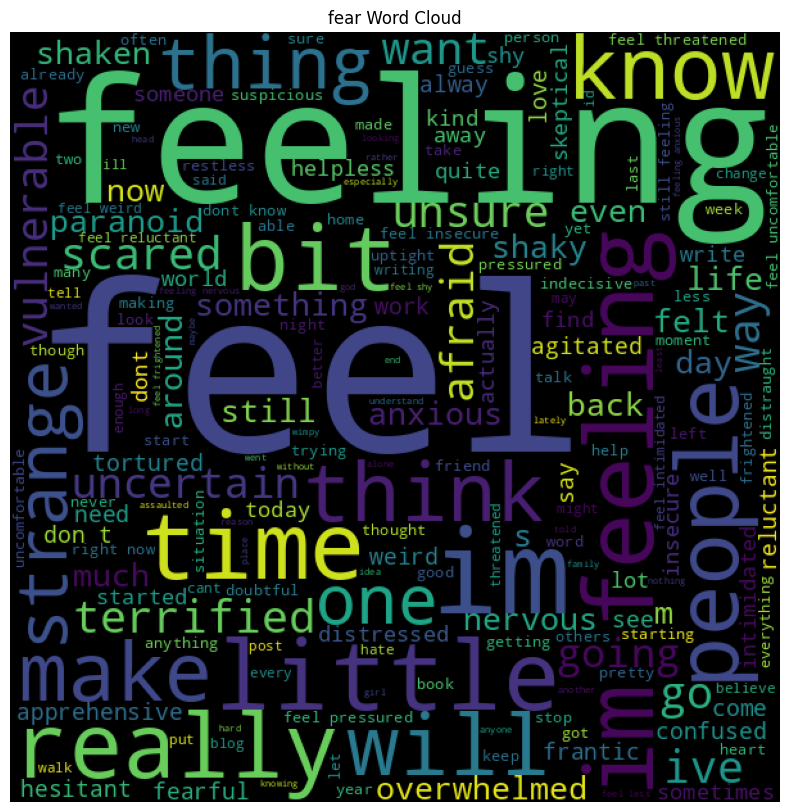

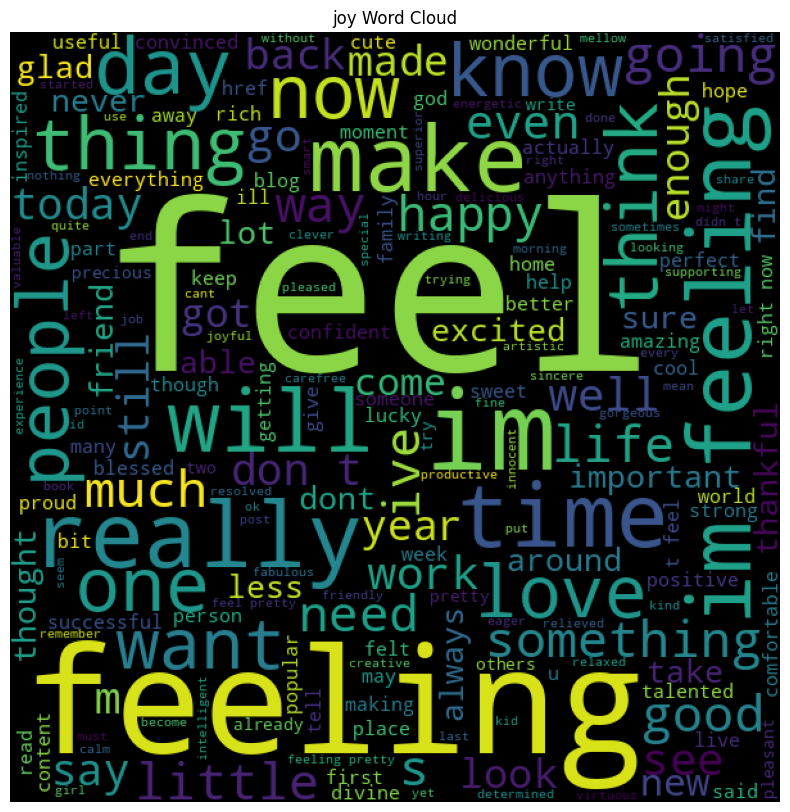

In [14]:
# word cloud for each emotion

def words_cloud(wordcloud,emotion):
    plt.figure(figsize=(10,10))
    plt.title(emotion+" Word Cloud")
    plt.imshow(wordcloud)
    plt.axis('off')

emotions_list=train_data['Emotion'].unique()

for emotion in emotions_list:
    text=" ".join([sentence for sentence in train_data.loc[train_data['Emotion']==emotion,'Comment']]) # this loop will run for every single emotion
    wordcloud=WordCloud(width=600,height=600).generate(text)
    words_cloud(wordcloud,emotion) # big words means it is used a lot on that sentence

In [15]:
# so wordcloud will remove stopwords and give us output in image

Data Preprocessing

In [16]:
# Encode emotions into numbers by labelEncoder

lb=LabelEncoder()
train_data['Emotion_Encoded']=lb.fit_transform(train_data['Emotion'])

In [17]:
train_data

,Comment,Emotion,length,Emotion_Encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [18]:
# Apply ML Libraries

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression # because we have multiple emotions(multiclass)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [19]:
df=train_data.copy() # copy df from train_data because we will use this in deep learning next

In [20]:
df

,Comment,Emotion,length,Emotion_Encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [21]:
# Clean the comment column text

import nltk
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words('english') # below are all the stopwords in english

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
def clean_text(text):
    stemmer=PorterStemmer() # converts words into their base meaning
    text=re.sub("[^a-zA-Z]"," ",text)
    text=text.lower()
    text=text.split()
    text=[stemmer.stem(word) for word in text if word not in stopwords]
    text=" ".join(text)
    return text
clean_text("Hi I am 3344 love")
df['cleaned_comment']=df['Comment'].apply(clean_text)

In [23]:
df

,Comment,Emotion,length,Emotion_Encoded,cleaned_comment
0,i didnt feel humiliated,sadness,23,4,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,108,4,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,48,0,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,92,3,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,20,0,feel grouchi
...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,sadness,102,4,turn feel pathet still wait tabl sub teach degre
15997,i feel strong and good overall,joy,30,2,feel strong good overal
15998,i feel like this was such a rude comment and i...,anger,59,0,feel like rude comment im glad


In [24]:
# Train-test split

X_train,X_test,y_train,y_test=train_test_split(df['cleaned_comment'],df['Emotion_Encoded'],test_size=0.2,random_state=42)

In [25]:
X_train

,cleaned_comment
676,refer cours though cant help feel somehow iron...
14180,would feel awkward someon tell feel toward
7077,feel like probabl would like book littl bit si...
13004,ive slow take time listen child moment feel li...
10264,feel vital rlsh gimmick need
...,...
13418,love leav reader feel confus slightli deceiv
5390,feel delic
860,start feel littl stress
15796,feel accept music critic reinforc concept music


In [26]:
X_train.shape

(12799,)

In [27]:
y_test.shape

(3200,)

In [28]:
# Vectorization using tf-idf

vectorizer=TfidfVectorizer()
X_train_vectorized=vectorizer.fit_transform(X_train)
X_test_vectorized=vectorizer.transform(X_test)

In [29]:
classifiers={
    "Multinomial Naive Bayes": MultinomialNB(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "SVC": SVC()
}

for name, clf in classifiers.items():
    print(f"\n-----------{name}-------------")
    clf.fit(X_train_vectorized, y_train)
    y_pred = clf.predict(X_test_vectorized)
    accuracy_tfidf=accuracy_score(y_test,y_pred)
    print("\nAccuracy using TFIDF:{accuracy_tfidf}")
    print("\nClassification Report:")
    print(classification_report(y_test,y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test,y_pred))


-----------Multinomial Naive Bayes-------------

Accuracy using TFIDF:{accuracy_tfidf}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.32      0.48       439
           1       0.88      0.23      0.37       375
           2       0.58      0.98      0.73      1027
           3       1.00      0.03      0.05       303
           4       0.72      0.91      0.80       950
           5       1.00      0.02      0.04       106

    accuracy                           0.66      3200
   macro avg       0.85      0.42      0.41      3200
weighted avg       0.76      0.66      0.59      3200


Confusion Matrix:
[[ 142    7  159    0  131    0]
 [   8   87  168    0  112    0]
 [   0    0 1002    0   25    0]
 [   0    0  251    8   44    0]
 [   0    1   81    0  868    0]
 [   0    4   68    0   32    2]]

-----------LogisticRegression-------------

Accuracy using TFIDF:{accuracy_tfidf}

Classification Report:
              precis

In [30]:
# Select model

lg=LogisticRegression()
lg.fit(X_train_vectorized,y_train)
y_pred_lg=lg.predict(X_test_vectorized)

Build Prediction System

In [31]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0] # for ex. converting 0 as anger
    label =  np.max(lg.predict(input_vectorized))

    return predicted_emotion,label

# Example usage
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Label :",label)
    print("================================================================")

i didnt feel humiliated
Prediction : sadness
Label : 4
i feel strong and good overall
Prediction : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Label : 0
He was speechles when he found out he was accepted to this new job
Prediction : joy
Label : 2
This is outrageous, how can you talk like that?
Prediction : anger
Label : 0
I feel like im all alone in this world
Prediction : sadness
Label : 4
He is really sweet and caring
Prediction : love
Label : 3
You made me very crazy
Prediction : sadness
Label : 4
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Label : 3
i am feeling grouchy
Prediction : anger
Label : 0
He hates you
Prediction : anger
Label : 0


Save the file

In [32]:
import pickle
pickle.dump(lg,open('logistic_regression.pkl','wb'))
pickle.dump(vectorizer,open('vectorizer.pkl','wb'))
pickle.dump(lb,open('label_encoder.pkl','wb'))